In [1]:
import pandas as pd

df = pd.read_csv("data/BankChurners.csv")
df.head()

/tmp/ipykernel_214081/1393203342.py:3: DtypeWarning: Columns (1,3,5,6,7,8,24,25,27,29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/BankChurners.csv")


,CustomerID,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Survey date,Twitter,Id Interaction,Interaction,Id Complain,date_received,product,sub_product,issue,sub_issue
0,708082083.0,Existing Customer,45.0,F,3.0,High School,Married,Less than $40K,Blue,36.0,...,23/10/2021,Ok I am LOVING THIS,1.0,Digital statement,511074.0,2013-08-30,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN
1,708083283.0,Attrited Customer,58.0,M,0.0,Unknown,Single,$40K - $60K,Blue,45.0,...,26/08/2021,I hate the mobile app it doesn’t work very well,2.0,Key lock,511080.0,2013-08-30,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN
2,708084558.0,Attrited Customer,46.0,M,3.0,Doctorate,Divorced,$80K - $120K,Blue,38.0,...,2021-05-10 00:00:00,Ok I am LOVING THIS,3.0,Delivery Cards,510473.0,2013-08-30,Credit reporting,NaN,Incorrect information on credit report,Account status
3,708085458.0,Existing Customer,34.0,F,2.0,Uneducated,Single,Less than $40K,Blue,24.0,...,2021-05-10 00:00:00,Appreciated you attention in the contact center,4.0,Theft and loss,510326.0,2013-08-30,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan
4,708086958.0,Existing Customer,49.0,F,2.0,Uneducated,Married,Unknown,Blue,41.0,...,2021-05-10 00:00:00,Appreciate the conversations and actions brou...,5.0,products and services acquisition,511067.0,2013-08-30,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount


In [2]:
df = df[['Twitter', 'NPS']]
df = df.dropna()

In [3]:
bins = [0, 6, 8, 110]
labels = [0, 1, 2]
df['NPS'] = pd.cut(df['NPS'], bins=bins, labels=labels, include_lowest=True)
df['NPS'] = df['NPS'].astype('Int64')

df['NPS'].value_counts(dropna=False)

NPS
2    6527
0    2167
1    1430
Name: count, dtype: Int64

In [4]:
df

,Twitter,NPS
0,Ok I am LOVING THIS,2
1,I hate the mobile app it doesn’t work very well,0
2,Ok I am LOVING THIS,1
3,Appreciated you attention in the contact center,2
4,Appreciate the conversations and actions brou...,0
...,...,...
10122,Ok I am LOVING THIS,0
10123,As amazing of this is,2
10124,As extremely amazing as this is,1
10125,I'm so exhausted from work this week that I pr...,2


In [5]:
# --- SBERT embeddings + clustering para ver si hay 3 grupos naturales ---
from sentence_transformers import SentenceTransformer

# 1. Seleccionar columna de texto
df_text = df[['Twitter']].dropna().reset_index(drop=True)
texts = df_text['Twitter'].tolist()

# 2. Cargar modelo SBERT (puedes cambiar a uno más grande si tu GPU lo soporta)
model_sbert = SentenceTransformer('all-MiniLM-L6-v2')

# 3. Generar embeddings
embeddings = model_sbert.encode(texts, show_progress_bar=True)


/home/ariel/Escritorio/proyectos/RoboAdvisoryGenAI/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-03 16:42:43.835083: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Batches: 100%|██████████| 317/317 [00:01<00:00, 164.22it/s]


In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 5. Evaluar distintos k
scores = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    scores.append((k, score))
    print(f"k={k}, silhouette={score:.3f}")

# 6. Elegir mejor k
best_k = max(scores, key=lambda x: x[1])[0]
print(f"\n→ Mejor número de clusters según silhouette: {best_k}")

# 7. Clustering final
km_final = KMeans(n_clusters=best_k, random_state=42)
labels_final = km_final.fit_predict(embeddings)
df_text['cluster'] = labels_final

k=2, silhouette=0.180
k=3, silhouette=0.216
k=4, silhouette=0.309
k=5, silhouette=0.349
k=6, silhouette=0.369

→ Mejor número de clusters según silhouette: 6


/home/ariel/Escritorio/proyectos/RoboAdvisoryGenAI/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


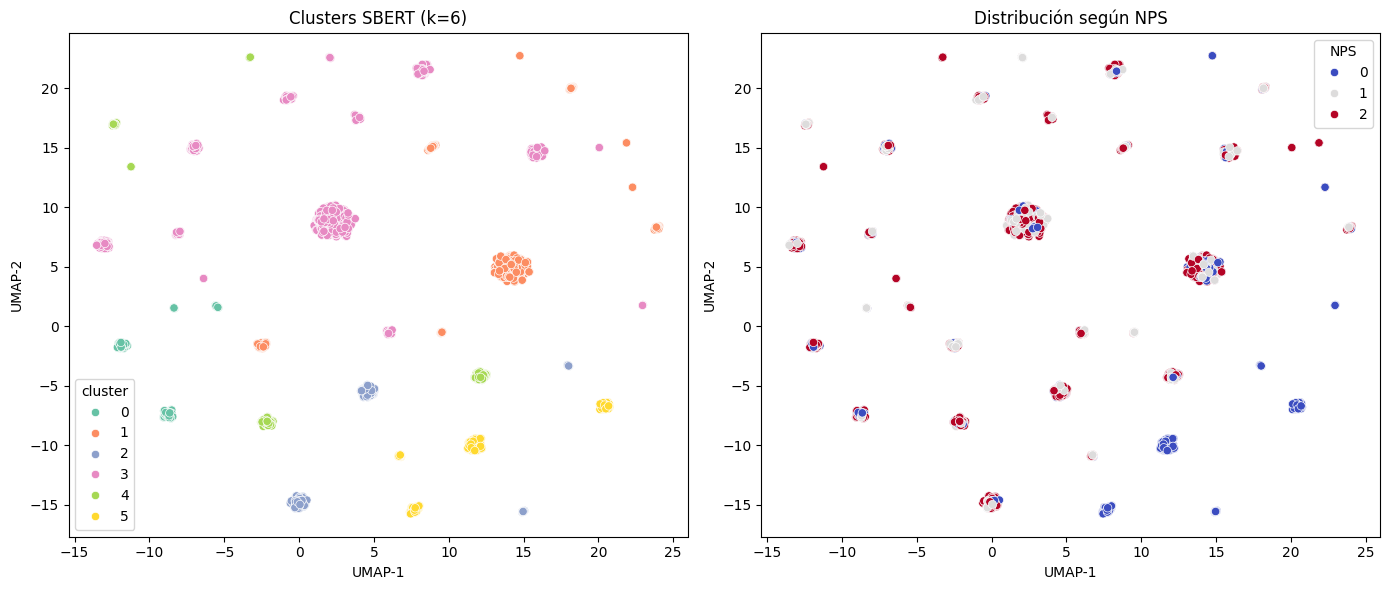

In [7]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
# 4. Reducir dimensionalidad con UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
emb_2d = reducer.fit_transform(embeddings)

# --- 8. Visualización lado a lado ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico 1: KMeans clusters
sns.scatterplot(
    x=emb_2d[:, 0], y=emb_2d[:, 1],
    hue=df_text['cluster'],
    palette="Set2", ax=axes[0], legend="full"
)
axes[0].set_title(f"Clusters SBERT (k={best_k})")
axes[0].set_xlabel("UMAP-1")
axes[0].set_ylabel("UMAP-2")

# Gráfico 2: Clasificación real (NPS)
sns.scatterplot(
    x=emb_2d[:, 0], y=emb_2d[:, 1],
    hue=df['NPS'],
    palette="coolwarm", ax=axes[1], legend="full"
)
axes[1].set_title("Distribución según NPS")
axes[1].set_xlabel("UMAP-1")
axes[1].set_ylabel("UMAP-2")

plt.tight_layout()
plt.show()


In [8]:
df_text.head()

,Twitter,cluster
0,Ok I am LOVING THIS,3
1,I hate the mobile app it doesn’t work very well,5
2,Ok I am LOVING THIS,3
3,Appreciated you attention in the contact center,0
4,Appreciate the conversations and actions brou...,0


In [9]:
df_text['cluster'].value_counts()

cluster
3    4353
1    2282
2    1034
5    1023
4     760
0     672
Name: count, dtype: int64

In [10]:
embeddings

array([[-1.3321148e-01,  1.0425124e-02,  8.7108783e-02, ...,
         1.3489504e-02, -1.1236965e-02, -2.2049727e-02],
       [-4.3428086e-02,  4.4255171e-02,  9.7671650e-02, ...,
         7.1436450e-02,  1.0378103e-02,  6.5008067e-02],
       [-1.3321148e-01,  1.0425124e-02,  8.7108783e-02, ...,
         1.3489504e-02, -1.1236965e-02, -2.2049727e-02],
       ...,
       [-9.1245413e-02,  2.7387368e-02,  2.4233481e-02, ...,
         2.9921314e-02, -3.4448728e-02,  5.0171543e-02],
       [-1.4461065e-03,  9.6935697e-04, -5.5176864e-05, ...,
         4.9249283e-03,  3.5782214e-02, -4.5037195e-02],
       [-7.9830877e-02,  1.1458136e-01,  4.3293033e-03, ...,
         5.1265065e-02,  5.4558776e-03, -9.0527937e-02]],
      shape=(10124, 384), dtype=float32)

In [11]:
for c in sorted(df_text['cluster'].unique()):
    print(f"\n--- Cluster {c} ---")
    cluster_tweets = df_text[df_text['cluster'] == c]['Twitter'].drop_duplicates()
    sample = cluster_tweets.sample(10, random_state=42, replace=True)
    for i, tweet in enumerate(sample, 1):
        print(f"{i}. {tweet}")


--- Cluster 0 ---
1. Appreciate you attention in the contact center
2. I want to say thank you
3. Appreciated you attention in the contact center
4. Appreciate you attention in the contact center
5. Appreciate you attention in the contact center
6. I want to say thank you
7. Appreciated you attention in the contact center
8. Appreciated you attention in the contact center
9. Appreciate you attention in the contact center
10. Appreciate the conversations  and actions brought together in new things with your products and service.

--- Cluster 1 ---
1. something
2. Wow
3. Very strange
4. Wow
5. Wow
6. Not nice.
7. Very strange
8. Very strange
9. Very strange
10. Wow

--- Cluster 2 ---
1. I’m really enjoying Black Card
2. I’m not  really enjoying Black Card
3. I don't like it
4. I’m not  really enjoying Black Card
5. I’m not  really enjoying Black Card
6. Yes, I have to give Call of Duty a break because this shit looks lit!
7. I don't like it
8. I don't like it
9. I don't like it
10. I’m 

In [12]:
df.to_csv("data/tweets.csv")